# Morpheme Analysis in NLP

In [1]:
import csv
import re
import string
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
import gensim
import gensim.downloader
import math
import matplotlib.pyplot as plot
from collections import defaultdict
from morphemes import Morphemes
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # idk why m1 needs this (https://stackoverflow.com/q/72441453)
from keras.utils import Sequence
from keras.models import Sequential, Model
from keras.layers import SimpleRNN, Dense, Activation, Input, LSTM

## Create Vocabulary (list of morphemes)

In [2]:
MO = Morphemes("./morphemes_files")

In [3]:
VOCAB = set()
VOCAB_LIST = [] # for tracking progress during debugging
with open('./morphemes_files/morpholex_words.csv') as file:
    reader = csv.reader(file)
    for row in reader:
        VOCAB.add(row[0].lower())
        VOCAB_LIST.append(row[0].lower())



## Morpheme Segmenter

See the `morpheme_segmenter_parallel.py` file for more information on how we use the `morphemes` library and MorphoLex to cache the moprheme results. The only problem is that the MorphoLex library does not account for inflectional morphemes, only derivational ones. This leaves us with a few choices. 

1. Ignore inflectional morphemes, but keep those words in VOCAB.
  
   This means that any last suffixes will be quite jumbled up (as inflectional morphology in English is always word-final).

2. Ignore any words in the VOCAB with inflectional morphemes.

   This would greatly reduce the size of our vocabulary as part of how MorphoLex is able to claim ~70k words derived is due to it containing multiple versions of the same word.

3. Add inflectional morphemes to the list of derived morphemes.

   This would require lemmatizing the words, determine what type of inflection is added onto it, and appending that to the word's morpheme list.
   Luckily, English only has a small set of inflectional morphemes. Note that the comparative suffixes (-er, -est) and past participle marker (-en) are considered a derivational morpheme by MorphoLex. We should also try not to split irregulars, as they are irregular, and words with more morphemes tend to be more regular. (In a way that's fair since these do change the meaning of a word.)

List of English inflections that we would have to find ourselves:
* (N) possession - 's
* (N) plural - s
* (V) 3rd person - s
* (V) past - ed
* (V) present continous - ing

Do note that when we use WordNet to get the definition of words, it makes no difference between these inflectional morphemes, which would suggest that the only reason we would want to split off inflections is so that our morpheme segmenter can learn where to cut these morphemes off.

In [4]:
# load in the pre-parsed morphemes from MorphoLex
VOCAB_MORPHEMES = {}
with open('./morphemes_files/morphemes_with_inflection.csv') as file:
    for word, spaced_morphemes in csv.reader(file):
        VOCAB_MORPHEMES[word] = spaced_morphemes.split()

In [5]:
def getMorphemeBoundaryIndices(word: str) -> list[int]:
    '''
    Returns a list of integers corresponding to the *general* position of the start of the next morpheme boundary.
    Note: the end of a word will not be included, hence a free morpheme/word of 1 morpheme will return an empty list.

    We say *general* position as orthotactic rules may cause additional letters to be inserted. eg. referral --> refer + 'r' + al

    eg.
    "import" --> [2]
     012345
    '''
    # get data from MorphoLex
    morphemes = VOCAB_MORPHEMES[word]

    # TODO: process the morphemes by scanning the word
    '''
    Phenomena that may occur if we assume at most one cha:
    letter doubling -- a + b --> abb, index should be at the first 'b'
    letter changing in both -- ab + cd --> aed, index should be at 'e'
    letter changing in left -- ab + c --> adc, index should be at 'd'
    letter changing in right -- a + bc --> adc, index should be at 'd'
    letter deletion in left -- a + bc -->
    '''
    indices = []
    # testing best contained strat linear
    i = 0
    lastState = True
    for morph, next_morph in zip(morphemes[:-1], morphemes[1:]):
        # imagin-e+a-ory --- a+cclimating
        j = 0
        def takeRest():
            nonlocal i; nonlocal j; nonlocal morph; nonlocal word; nonlocal next_morph
            while j < len(morph) and i < len(word):
                if word[i] == morph[j]: # taking matches
                    i += 1
                    j += 1
                elif word[i] == next_morph[0]:
                    indices.append(i)
                    return False # imperfect finish
                else: # change in both morphemes
                    indices.append(i)
                    return False
            indices.append(i)
            return True # perfect finish

        # good start
        if word[i] == morph[j] and len(morph) == 1: # good start
            lastState = takeRest()
        elif word[i] == morph[j] and word[i+1] == morph[j+1]: # good start no doubling
            lastState = takeRest()  
        elif word[i] == morph[j] and word[i+1] != morph[j+1]: # doubbling likely
            i += 1
            lastState = takeRest()
        else:
            if i+1 < len(word) and word[i+1] == morph[j]: # changed left morpheme
                if not lastState:
                    indices.pop()
                    i += 1
                    indices.append(i) # must fix an early taking *in vs *im
                else:
                    i += 1
                lastState = takeRest() 
            else: # changed right morpheme
                i += 1
                print('the foresaken changed right morpheme in:', word)
                lastState = takeRest()

    return indices


In [6]:
# words to test: 
# imaginary => imagin-e+a.-ory --> [6]
# referral => refer+r.al --> [5]
# electronic => electr.on.ic --> [6, 8]
# acclimate => a.+cclimate --> [1]
# regression => re.gress.ion --> [2, 7]
# implication => i-n+m.plic.at-e.i.on --> [2, 6, 8]
# impressive => i-n+m.press.ive --> [2, 7]
# trigonometry => tri.gono.met-er.y --> [3, 7, 11], ugh the metry is irregular
# assemblywomen => a.+ssembl-e.y.women --> [1, 7, 8]
# bisexually => bi.sex+u.al.ly --> [2, 5, 8] or [2, 6, 8] depending on how the u is analyzed
# unacknowledged => un.a.+cknow.ledge.d --> [2, 3, 8, 13]
# intonations => in.ton-a+e.+tion.s --> [2, 6, 7, 10]
for word in ('imaginary', 'referral', 'electronic', 'acclimate', 'regression', 'implication', 'impressive', 'trigonometry', 'assemblywomen', 'bisexually', 'unacknowledged', 'intonations', 'allegories'):
    print(VOCAB_MORPHEMES[word])
    print(getMorphemeBoundaryIndices(word)) 


['imagine', 'ory']
[6]
['refer', 'al']
[5]
['electr', 'on', 'ic']
[6, 8]
['a', 'climate']
[1]
['re', 'gress', 'ion']
[2, 7]
['in', 'plic', 'ate', 'ion']
[2, 6, 8]
['in', 'press', 'ive']
[2, 7]
['tri', 'gono', 'meter', 'y']
[3, 7, 10]
['a', 'semble', 'y', 'women']
[1, 7, 8]
['bi', 'sex', 'al', 'ly']
[2, 5, 8]
['un', 'a', 'know', 'ledge']
[2, 3, 8]
['in', 'tone', 'ion', 's']
the foresaken changed right morpheme in: intonations
[2, 5, 6]
['allegor', 'y', 's']
the foresaken changed right morpheme in: allegories
[7, 8]


In [7]:
VOCAB_morpheme_boundaries = {}
for word in VOCAB_LIST:
    VOCAB_morpheme_boundaries[word] = getMorphemeBoundaryIndices(word)

the foresaken changed right morpheme in: pasties
the foresaken changed right morpheme in: navies
the foresaken changed right morpheme in: bakers
the foresaken changed right morpheme in: feeding
the foresaken changed right morpheme in: feedings
the foresaken changed right morpheme in: feeds
the foresaken changed right morpheme in: allegories
the foresaken changed right morpheme in: altitudes
the foresaken changed right morpheme in: amphibians
the foresaken changed right morpheme in: anatomies
the foresaken changed right morpheme in: ancestries
the foresaken changed right morpheme in: zimbabweans
the foresaken changed right morpheme in: worsening
the foresaken changed right morpheme in: worthies
the foresaken changed right morpheme in: wranglers
the foresaken changed right morpheme in: wrestlers
the foresaken changed right morpheme in: wrigglers
the foresaken changed right morpheme in: zaireans
the foresaken changed right morpheme in: wesleyans
the foresaken changed right morpheme in: wh

In [8]:
VOCAB_morpheme_boundaries['bakers']

[4, 5]

### RNN Morpheme Segmenter
Here we *would* train a morpheme segmenter using an RNN, but that's actually not required for the task on hand. However it's still useful in a study of morphology.

## Morpheme Embeddings

In [9]:
# first we generate the set of morphemes in English (or at least in our dataset)
MORPHEMES = defaultdict(lambda : []) # morphemes: m -> [words containing m]
for word in VOCAB_LIST:
    morphemes_of_word = VOCAB_MORPHEMES[word]
    for m in morphemes_of_word:
        MORPHEMES[m].append(word)

Now that we have a collection of words that each share a morpheme, we try to embed these morphemes by having each morpheme be the average word2vec of each word the morpheme is in.

eg. bio: biotic, biographic, biologist, ...  
embed(bio) = average(w2v(biotic), w2v(biographic), w2v(biologist))

In [10]:
# getting the word2vec embeddings
# technically we use GloVe, but they are easily interchangable
w2v = gensim.downloader.load('glove-wiki-gigaword-300')

In [11]:
# getting the lemmatizer
lemmatizer = nltk.WordNetLemmatizer()

In [12]:
def average_np_matrices(*arr):
    sum_arr = np.copy(arr[0])
    for a in arr[1:]:
        sum_arr = sum_arr + a
    return sum_arr / len(arr)

def dotprod(u, v):
    total = 0
    for m, n in zip(u, v):
        total += m*n
    return total

def dist(v):
    return math.sqrt(sum(map(lambda x : x*x, v)))

def cosineSimilarity(u, v):
    return dotprod(u, v) / (dist(u) * dist(v))

def scatterplot(matrix, labels, colors = None):
    plot.scatter(matrix[:,0], matrix[:,1], c = colors)
    for i in range(matrix.shape[0]):
        x = matrix[i][0]
        y = matrix[i][1]
        plot.annotate(labels[i], (x, y))


In [13]:
MORPHEME_EMBED = {}
for morpheme, containing_words in MORPHEMES.items():
    # note, if a word isn't lemmatized, it won't be able to vectorize it! TODO: try lemmatizing (will unequal weight)
    vectors = list(map(lambda word : w2v[word], (word for word in containing_words if word in w2v)))
    if len(vectors) == 0:
        print(morpheme)
        continue
    MORPHEME_EMBED[morpheme] = average_np_matrices(*vectors)


alf
aliquot
alpenhorn
alpenstock
amanuenses
anaplasmosis
anastomotic
's
'tis
woodbury
y'know
yobbo
williamson
verruca
virgule
valetudinary
truckle
trumpery
tumbrel
tumid
turp
twilit
trepan
trephine
titivate
terpsichorean
terramycin
terylene
thiouracil
thraldom
throve
thyratron
thyrotoxic
tapster
temerarious
surtout
swiz
summat
suppurate
surcease
surd
strewth
spume
stephanotis
stertorous
sozzle
spatchcock
spavin
splodge
snivel
soignee
solecism
soutane
skirl
sluggard
shrive
sillabub
simoon
skewbald
serviette
severalty
sforzando
shaddock
shindy
shouldst
scurf
scutcheon
secateurs
sedulous
sempstress
sepulture
serbantian
saveloy
scallywag
scantling
scatty
scrag
scrimshank
scrofulous
scrota
sanatarium
sande
rowlock
rubicund
retrousse
riemann
rissole
repine
recreant
rallentando
ratiocinate
pudendum
purblind
pyknotic
quean
prognathous
prokofieff
prithee
poltroon
pommy
poniard
pornsen
posset
postilion
pother
poulterer
planoconcave
plash
podgy
piccaninny
pilau
pillock
pinny
pelf
pelmet
percipien

In [14]:
MORPHEMES['bio']

['biotic',
 'bioscopes',
 'bioscope',
 'biographic',
 'biographies',
 'biographer',
 'biographers',
 'biography',
 'biologic',
 'biologist',
 'biologists',
 'biology',
 'biographical',
 'biological',
 'biographically',
 'biologically',
 'symbiosis',
 'macrobiotic',
 'antibiotics',
 'antibiotic',
 'antibiotically',
 'microbiologist',
 'microbiologists',
 'autobiographies',
 'microbiology',
 'biosynthesized',
 'autobiographic',
 'autobiography',
 'microbiological',
 'autobiographical',
 'autobiographically']

In [15]:
cosineSimilarity(MORPHEME_EMBED['bio'], w2v['biologist'])
# cosineSimilarity(w2v['antibiotic'], w2v['biology'])

0.38174362822160757

Let's do a quick analysis as a sanity check that what we are doing works:

We will be taking a subset of morphemes, getting the words of each of those morphemes, then applying a PCA across all of these vertices and plotting their first 2 largest axes to check if the morpheme-representations align with their source words:

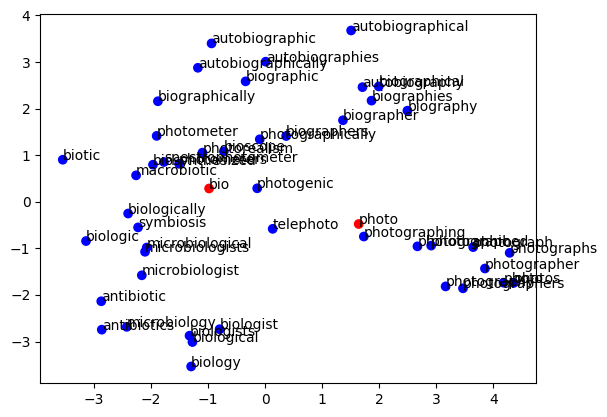

In [16]:
def morpheme_embedding_sanity_check():
    pca = PCA(n_components=2)
    subset_morphemes = ['photo', 'bio']
    subset_words = [w for m in subset_morphemes for w in MORPHEMES[m] if w in w2v]
    all_labels = subset_morphemes + subset_words
    all_representations = [MORPHEME_EMBED[m] for m in subset_morphemes] + [w2v[w] for w in subset_words]
    result = pca.fit_transform(np.stack(all_representations))
    scatterplot(result, all_labels, ['red']*len(subset_morphemes) + ['blue']*len(subset_words))

morpheme_embedding_sanity_check()

In conclusion, it's alright, but not the best. There's still quite a lot of overlap between 'photo' and 'bio' morphemes. This probably has more to do with how word2vec doesn't actually contain any information on semantics, rather it is context-based (based on the surrounding words).

Maybe we can improve this by creating our own PCA dimensions across our morpheme's word embeddings, then everytime we want to lookup a word, we have to do a `word str --w2v--> w2v vec --project--> pca vec`.

## Encoder-Decoder for mapping definitions to words

Before we set up our Encoder-Decoder RNN structures, here are the parameters:

**Encoder**:
* Input: a sequence of w2v representations (coming from a definition)

**Decoder**:
* Output: a sequence of morphemes (coming from our set of morphemes)

In [17]:
morphemes_in_order = list(MORPHEMES.keys())
morphemes_in_order.sort()
len(MORPHEMES) # number of morphemes we in our dataset

15548

We may want to filter stopwords in to get rid of noise within the model.

In [18]:
# let's get the stopwords list
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/siraire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
def process_definition(definition, remove_stopwords = False):
    dws = (dw for dw in nltk.word_tokenize(definition) if (dw not in stops if remove_stopwords else True))
    return [w2v[dw] for dw in dws if dw in w2v]

# we can get definitions of a word like this:
def get_definitions(word: str, remove_stopwords = False) -> list[list[str]]:
    '''
    Returns a list of definitions where each definition is tokenized into words.
    '''
    syns = wordnet.synsets(word)
    if remove_stopwords:
        return [[w for w in nltk.word_tokenize(syn.definition()) if w not in stops and w not in string.punctuation] for syn in syns]
    else:
        return [[w for w in nltk.word_tokenize(syn.definition()) if w not in string.punctuation] for syn in syns]
        

In [20]:
len(process_definition('a game of chess', True))

2

In [21]:
get_definitions('game', True)

[['contest', 'rules', 'determine', 'winner'],
 ['single', 'play', 'sport', 'contest'],
 ['amusement', 'pastime'],
 ['animal', 'hunted', 'food', 'sport'],
 ['tennis', 'division', 'play', 'one', 'player', 'serves'],
 ['games', 'score', 'particular', 'point', 'score', 'needed', 'win'],
 ['flesh', 'wild', 'animals', 'used', 'food'],
 ['secret',
  'scheme',
  'something',
  'especially',
  'something',
  'underhand',
  'illegal'],
 ['game', 'equipment', 'needed', 'order', 'play', 'particular', 'game'],
 ['occupation', 'line', 'work'],
 ['frivolous', 'trifling', 'behavior'],
 ['place', 'bet'],
 ['disabled', 'feet', 'legs'],
 ['willing', 'face', 'danger']]

In [22]:
# now let's use w2v to get all of the definitions of a word and encode them
# note that a given word has multiple definitions
int_to_morpheme : list[str] = morphemes_in_order.copy()
# NOTE: the first int (0) needs to be reserved as 'no morpheme'
# and we need another int (1) to be reserved as 'start morpheme'
START_MORPHEME = '^'
END_MORPHEME = '$'
int_to_morpheme.insert(0, END_MORPHEME)
int_to_morpheme.insert(1, START_MORPHEME)
morpheme_to_int : dict[str, int] = {m: i for i, m in enumerate(int_to_morpheme)}

input_definition_embeddings : list[list[float]] = [] 
output_morphemes : list[list[int]] = []
output_words : list[str] = [] # just so it's easier to track

for word in VOCAB_LIST:
    for definition in get_definitions(word, True):
        input_definition_embeddings.append([w2v[dw] for dw in definition if dw in w2v]) # we just ignore def-words that don't have embeddings
        output_morphemes.append([morpheme_to_int[START_MORPHEME]] + [morpheme_to_int[m] for m in VOCAB_MORPHEMES[word]]) # TODO: REMOVE INFLECTION AS IT BASICALLY JUST REDUCES THE PROBABILITY OF BEING CORRECT BY A LOT!!!
        output_words.append(word)

# encoder_input_data = np.zeros((), dtype='float32')

In [23]:
process_definition('')

[]

In [24]:
int_to_morpheme[0:5]

['$', '^', "'s", "'tis", '(altern)>ate>']

In [25]:
# let's find the max length of the embedding(definition_sentence) --- this will be used to set the size of our np input array
max_definition_length = max(len(definition) for definition in input_definition_embeddings)

# let's also assume the max morpheme length in a word is 10 (in the dataset, it is less)
max_morphemes_in_a_word = 10

# w2v rep length
size_of_representation = len(input_definition_embeddings[0][0])

# output domain
number_of_morphemes = len(morpheme_to_int)

# our n sample size (number of definitions we have)
overall_sample_size = len(input_definition_embeddings)

# now let's numpy-ify our data
# NOTE: for np[x,y,z], x: xth sample, y: yth dw/morpheme, zth w2v-rep/one-hot rep
encoder_input_data = np.zeros(
    (overall_sample_size, max_definition_length, size_of_representation),
    dtype='float32')
decoder_input_data = np.zeros(
    (overall_sample_size, max_morphemes_in_a_word, number_of_morphemes),
    dtype='float32'
)
decoder_target_data = np.zeros(
    (overall_sample_size, max_morphemes_in_a_word, number_of_morphemes),
    dtype='float32'
)
for i, (definition, target_morphemes) in enumerate(zip(input_definition_embeddings, output_morphemes)):
    for t, dw_embed in enumerate(definition):
        encoder_input_data[i, t] = dw_embed
    for t, morpheme in enumerate(target_morphemes):
        decoder_input_data[i, t, morpheme] = 1.
        if t > 0:
            decoder_target_data[i, t-1, morpheme] = 1.

In [26]:
class DataGenerator(Sequence): # https://stackoverflow.com/a/71592809
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
class EncoderDecoder:
    def __init__(self, 
             size_encoder_rep,
             size_decoder_rep,
             batch_size = 64, 
             epochs = 50, 
             latent_dim = 256, # size of hidden dimension
             decoder_activation = 'softmax',
             optimizer = 'rmsprop', 
             loss = 'categorical_crossentropy',
             validation_split = 0.2
            ):
        # saving arguments
        self.size_encoder_rep = size_decoder_rep
        self.size_decoder_rep = size_decoder_rep
        self.batch_size = batch_size
        self.epochs = epochs
        self.latent_dim = latent_dim
        self.optimizer = optimizer
        self.loss = loss
        self.validation_split = validation_split

        # setting up encoder
        self.encoder_inputs = Input(shape=(None, size_encoder_rep))
        self.encoder = LSTM(latent_dim, return_state=True)
        self.encoder_outputs, self.state_h, self.state_c = self.encoder(self.encoder_inputs)
        self.encoder_states = [self.state_h, self.state_c]
        
        # setting up decoder
        self.decoder_inputs = Input(shape=(None, size_decoder_rep))
        self.decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
        self.decoder_outputs, _, _ = self.decoder_lstm(self.decoder_inputs, initial_state=self.encoder_states)
        self.decoder_dense = Dense(size_decoder_rep, activation=decoder_activation)
        self.decoder_outputs = self.decoder_dense(self.decoder_outputs)

        # defining the model that turns encoder_inputs + decoder_inputs --> decoder_target_data
        self.model = Model([self.encoder_inputs, self.decoder_inputs], self.decoder_outputs)

    def train(self, encoder_input_data, decoder_input_data, decoder_target_data):
        # X = DataGenerator()
        with tf.device('/gpu:0'):
            self.model.compile(optimizer=self.optimizer, loss=self.loss)
            self.model.fit([encoder_input_data, decoder_input_data], 
                        decoder_target_data,
                        batch_size=self.batch_size,
                        epochs=self.epochs,
                        validation_split=self.validation_split)
        
    def save(self, path):
        self.model.save(path)

    def load(self, path):
        self.model = tf.keras.models.load_model(path)

    def predict(self, start_value_rep, stop_value_rep, input_seq, max_output_len):
        # inference setup
        encoder_model = Model(self.encoder_inputs, self.encoder_states)

        decoder_state_input_h = Input(shape=(self.latent_dim,))
        decoder_state_input_c = Input(shape=(self.latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        decoder_outputs, state_h, state_c = self.decoder_lstm(
            self.decoder_inputs, initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = self.decoder_dense(decoder_outputs)
        decoder_model = Model(
            [self.decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states
        )

        # predicting output
        states_value = encoder_model.predict(input_seq)
        target_seq = np.zeros((1,1, self.size_decoder_rep))
        target_seq[0, 0, start_value_rep] = 1

        stop_condition = False
        output = []
        while not stop_condition:
            output_tokens, h, c = decoder_model.predict(
                [target_seq] + states_value
            )
            sampled_token_index = np.argmax(output_tokens[0, -1, :]) # chooses the most likely
            output.append(sampled_token_index)

            if sampled_token_index == stop_value_rep or len(output) > max_output_len:
                stop_condition = True

            # update target sequence to last output char
            target_seq = np.zeros((1, 1, self.size_decoder_rep))
            target_seq[0, 0, sampled_token_index] = 1.
            states_value = [h, c]

        return output

In [27]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [31]:
DefinitionToMorphemesED = EncoderDecoder(
    size_encoder_rep=size_of_representation,
    size_decoder_rep=number_of_morphemes,
)

In [32]:
print(np.shape(encoder_input_data))
encoder_input_data[0,0,:]

(177350, 35, 300)


array([-2.6465e-01, -2.4113e-01, -9.7393e-02, -5.6043e-01,  2.6969e-01,
        5.2157e-01, -3.3869e-01,  4.1125e-02,  4.1211e-01, -1.5943e+00,
        5.2922e-01,  4.6474e-01, -7.1468e-02,  1.9330e-01, -7.1184e-01,
       -1.0516e-01, -3.1934e-01,  2.6642e-01,  4.5151e-01,  5.4538e-01,
        1.3934e-01, -3.4511e-01, -2.5835e-01, -2.4294e-01, -3.2396e-01,
       -1.8739e-01,  1.4732e-01, -4.0996e-03, -4.3465e-02,  2.3815e-01,
        1.5484e-01,  2.0076e-01,  2.0635e-01,  4.1099e-01, -7.9007e-01,
        1.7084e-01,  1.6690e-01, -5.8678e-01, -2.7173e-01,  2.5888e-01,
       -9.1765e-02, -2.7044e-01, -1.3084e-01,  2.5999e-01, -1.7353e-01,
        2.4524e-01,  3.7556e-01,  4.2925e-01, -7.7404e-01,  6.8347e-02,
        2.7238e-01, -2.8643e-01,  1.7209e-01, -2.8911e-01, -3.3902e-01,
        1.3517e-01,  1.0065e-01, -4.5808e-02,  4.7627e-01, -2.3999e-01,
        2.1710e-02, -1.3571e-01, -2.3606e-01,  1.8775e-01, -5.3124e-01,
       -7.2774e-01,  3.4354e-01, -4.9749e-02, -3.6158e-01, -3.65

In [33]:
DefinitionToMorphemesED.train(encoder_input_data, decoder_input_data, decoder_target_data)

Epoch 1/50
 100/2217 [>.............................] - ETA: 12:10 - loss: 1.3121

KeyboardInterrupt: 